# "Class Activation Map"
> "Class Activation Map explained"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Pramesh Gautam
- categories: [computer-vision]

In [1]:
# imports

import ast
import json
from copy import deepcopy

import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models, transforms


# CAM

Class activation map was introduced in [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150). It was introduced to use the classifier networks for localization tasks. However it can also be used to interpret the models and figure out where the network focuses to classify a input. It uses the weights in the final layer to weight the feature maps in the final convolution layer. That weighted sum is used to see the activation map.

![Class activation map computation](https://github.com/pmgautam/personal-blog/blob/master/images/CAM.png?raw=true)

As seen in the figure above, once the input image passes through the CONV layers, let's say it produces feature map  of shape $1\times2048\times7\times7$ in the format $B \times C \times H \times W$ format. Global Average Pooling will then sum the spatial dimension and produce output of shape $1\times2048$ after collapsing across spatial dimension. There will be $2048\times1000$ weights mapping from output of GAP layer to final layer (1000 number of classes in ImageNet). Once we classify the image, the corresponding 2048 weights mapping from GAP layer to FC layer are used to weight the 2048 spatial features of the last convolutional layer. These weighted features are then resized to the input image size to get the final feature map.

## Pytorch Hooks
We'll be using PyTorch hooks to extract the intermediate feature maps. Hooks are the functions that can be executed during forward or backward pass of the network. You can learn model about hooks [here](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/).

Here we are using hooks to save the feature maps of **layer4**, i.e. the final convolutional layer. We multiply the output of **layer4** by the weights that map from avgpool layer to fc layer. Since weights can be extracted from the model itself, we only use hooks to save the output of laster convolutional layer.

In [2]:
# define hooks to save activation
activation = {}

def get_activation(name):
    def hook(model, input, output):        
        activation[name] = output.detach()
    return hook

Once we define attach hook to the model, the output of the layer to which the hooks was attached will be saved in the **activation** dictionary.

In [3]:
# define function to get predictions and required activations

def get_data(input_image, model, transforms):
    # transform input image
    input_data = transform(imageio.imread(input_image)).unsqueeze(0)
    
    # imagenet labels to map from index to text label
    labels = ast.literal_eval(open("imagenet1000_clsidx_to_labels.txt").read())
    
    # attach hook to layer 4
    model.layer4.register_forward_hook(get_activation("layer4"))
    
    model.eval();
    with torch.no_grad():
        preds = model(input_data)
        preds_softmax = torch.nn.functional.softmax(preds, dim=1)
        top_prob, top_pred = preds_softmax.max(dim=1)

        return top_pred, top_prob, labels[top_pred.item()], activation

In [4]:
# image to test CAM
image = "https://github.com/pmgautam/personal-blog/blob/master/images/n02102040_7490.JPEG?raw=true"

# model to run inference
model = models.resnet50(pretrained=True)

# transforms to use ImageNet values for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# results
pred_class, pred_prob, pred_label, activation = get_data(image, model, transforms)

pred_class, pred_prob, pred_label

(tensor([217]), tensor([0.8239]), 'English springer, English springer spaniel')

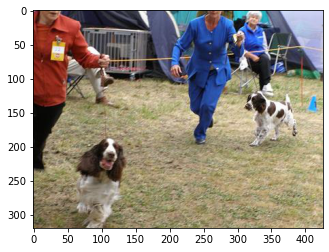

In [5]:
# input image
input_img = imageio.imread(image)
plt.imshow(input_img);

In [6]:
# extract weights from FC layer that correspond to the predicted class

fc_weights = model.fc.weight[pred_class, :].unsqueeze(2).unsqueeze(3)
fc_weights.shape

torch.Size([1, 2048, 1, 1])

In [7]:
# check shape of final convolutional layer
activation["layer4"].shape

torch.Size([1, 2048, 10, 14])

In [8]:
# weighted summation of final feature maps

res=torch.einsum("bchw,bchw->bhw", fc_weights, activation["layer4"])
res.shape

torch.Size([1, 10, 14])

In [9]:
# add dimension to make compatible with interpolation

combined_cam = res.unsqueeze(0)
combined_cam.shape

torch.Size([1, 1, 10, 14])

In [10]:
# reshape cam to original input shape
final_cam = F.interpolate(combined_cam, tuple(input_img.shape[:2]), mode="bilinear")

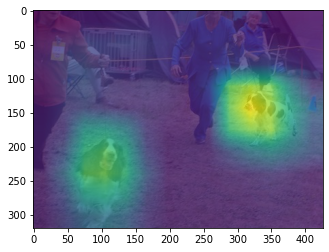

In [11]:
# plot input image with CAM overlayed
plt.imshow(input_img)
plt.imshow(final_cam.squeeze().detach().numpy(), alpha=0.8)

plt.show()

As can be seen in the plot above, the network is able to focus on the dogs while classification. We can weight the features first and then resize the image or we can resize the features first and use the weighted combination. The results are identical. Below I have first resized the final feature maps and then used their weighted combination for plotting.

In [12]:
# resizing the feature maps and then weighting
features = F.interpolate(activation["layer4"], tuple(input_img.shape[:2]), mode="bilinear")

final_res=torch.einsum("bchw,bchw->bhw", fc_weights, features)
final_res.shape

torch.Size([1, 320, 426])

In [13]:
features.shape

torch.Size([1, 2048, 320, 426])

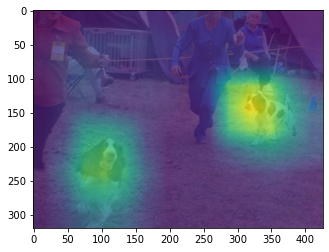

In [14]:
plt.imshow(input_img)
plt.imshow(final_res.squeeze().detach().numpy(), alpha=0.8);

I hope this blog was useful to understand Class Activation Maps. I will add Grad-CAM in future post. Please feel free to open pull requests or comment if you see anything needs to be corrected or if you have any questions. I'll see you in the next one.

Bye :)